In [1]:
#! pip install pyadi-iio

In [2]:
import adi

In [3]:
#! pip install matplotlib
#! pip install scikit-dsp-comm
#! pip install scikit-commpy
#! pip install statsmodels

In [4]:
Uri = "ip:192.168.1.35"
sdr = adi.Pluto(Uri)

In [5]:
#------------------------------- Libraries ------------------------------- 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm, probplot

Por otra parte, para observar el efecto que producen los cambios de configuración a realizar, nos valdremos de dos señales. La primera de ellas es la exponencial compleja que nos permitirá enviar por la componente en fase una señal cosenoidal y por la componente en cuadratura una señal senoidal:

$$ s(n T_{s}) = \textrm{exp}(j 2 \pi f_{c} n T_{s})= cos( 2 \pi f_{c} n T_{s}) + j sen( 2 \pi f_{c} n T_{s})$$

Esta señal es implementada con el siguiente código

In [6]:
def complexExp(N,Fc,Fs):
    # N : Number of samples to transmit at once
    # Fc: Carrier frequency in Hz
    # Fs: Sampling frequency in Hz
    if Fs < 2*Fc:
        raise ValueError(
            "Error: Fs must be at least 2 time Fc"
        )
    Tsamp  = 1/Fs;
    n      = np.arange(N)
    signal = 1.0*np.exp(1j*2.0*np.pi*Fc*n*Tsamp) 
    return signal

In [7]:
nSamples     = 2**20
samplingRate = 2.0e6
frec         = samplingRate/8
txSignalExp  = complexExp(nSamples,frec,samplingRate)

In [8]:
def plotSignal(signal):
#------------------------------- Transmitted I component ------------------------------- 
# Plot time domain
    plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(2,1,1)
    plt.plot(np.real(signal))
    plt.xlabel('n')
    plt.ylabel('Amplitud')
    plt.title('Componente en fase de la señal')
    plt.grid()
#------------------------------- Transmitted Q component -------------------------------
# Plot time domain
    plt.subplot(2,1,2)
    plt.plot(np.imag(signal))
    plt.xlabel('n')
    plt.ylabel('Amplitud')
    plt.title('Componente en cuadratura de la señal')
    plt.grid()
    plt.show()

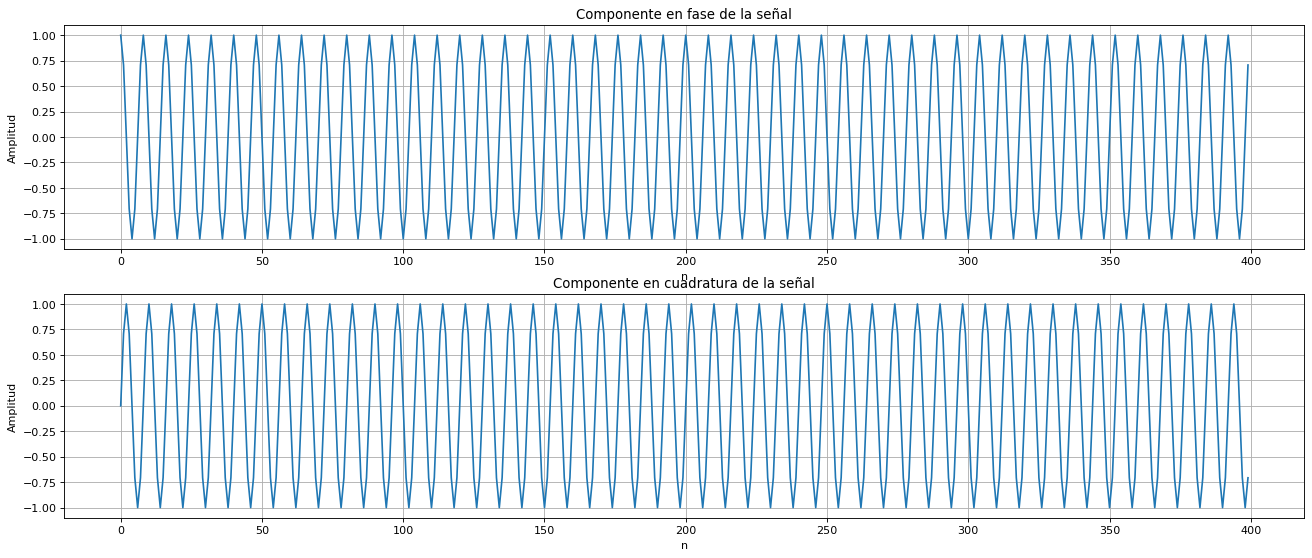

In [9]:
plotSignal(txSignalExp[0:400])

La gráfica del espectro de densidad de potencia puede obtenerse a partir del siguiente código

In [10]:
def plotSpect(signal,samplingRate):
    plt.subplots(figsize=(15, 3))
    plt.grid()
    plt.title("Power Spectral Density")
    plt.psd(signal, len(signal), samplingRate, color='C1')
    plt.show()

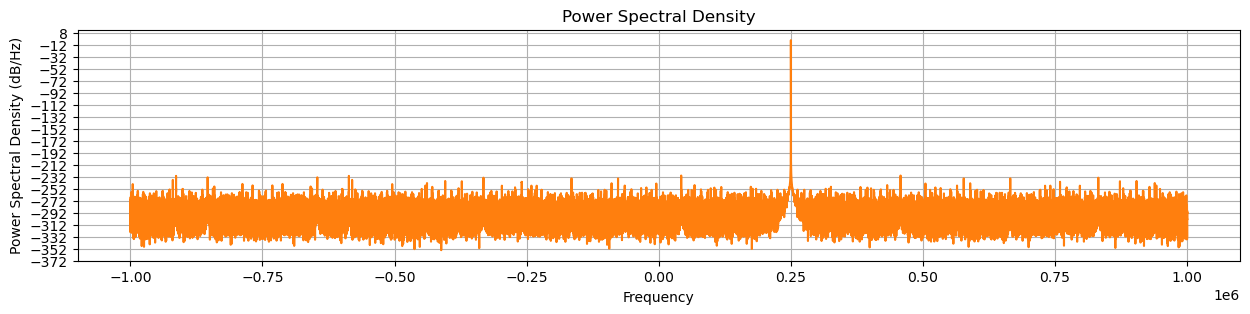

In [11]:
plotSpect(txSignalExp,samplingRate)

## Parámetros de configuración del SDR

In [12]:
#------------------------------- SDR Parameter Configuration -------------------------------

Uri              = Uri
Loopback         = 0             # 0=Disabled, 1=Digital loopback, 2=Retransmiter
SamplingRate     = samplingRate  # Sample rate RX and TX paths[Samples/Sec]

TxLOFreq         = 946e6         # Carrier frequency of TX path [Hz]
TxAtten          = -70           # Attenuation applied to TX path, valid range is -89 to 0 dB [dB]
TxRfBw           = 2.0e6         # Bandwidth of front-end analog filter of TX path [Hz]
RxBufferSize     = nSamples      # Depend on the length of the transmit signal. Maximum tx buffer size 2**24[samples]
tx_cyclic_buffer = False

RxLOFreq         = TxLOFreq      # Carrier frequency of RX path [Hz]
GainControlModes = "manual" # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 70            # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'    
RxRfBw           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz] 
RxBufferSize     = 2**20       # Rx Buffer size. Maximun value 2**28 [Samples]

## Lazo de retorno
El primer parámetro de configuración es el lazo de retorno o Loopback. Como se puede observar en la Figura 2, el chip posee un bloque que permite enviar, de forma directa, la señal digital ingresada en los pines de entrada del transmisor hacia los pines de salida del receptor, sin pasar por ninguna de las etapas del transceptor. Esta configuración se consigue seteando el parámetro "sdr.loopback" con el valor 1. En caso de setearlo con el valor 2, el transceptor funcionará como un repetidor, emitiendo por el transmisor la señal recibida por el receptor. Para desactivar cualquier tipo de lazo de retorno se debe cargar el parámetro con el valor 0. 
- **Rango de valores del lazo de retorno:**
 - **0: Desactivado**
 - **1: Realimentación de la señal digital**
 - **2: Realimentación de la señal de RF**

In [13]:
sdr.loopback = Loopback

## Frecuencia de muestreo
El segundo parámetro de configuración a describir es el "sdr.sample_rate". Este parámetro define la frecuencia a la cual el AD9363 va a estar procesando las muestras digitales correspondientes a las componentes en fase y en cuadratura de la parte transmisora y receptora. Para el caso en que los datos digitales sean generados o entregados un Host remoto de forma continua, como por ejemplo una computadora, la máxima frecuencia de muestreo a configurar va a depender del límite de velocidad soportado por el tipo de conexión al Host remoto.

- **Rango de la frec. de muestreo: 521 KSPS a 61.44 MSPS**

In [14]:
# sdr.sample_rate = samplingRate  # Sample rate RX and TX paths[Samples/Sec]

## Ancho de banda en RF
En la parte receptora, la señal que sale de los mezcladores de RF es filtrada para eliminar los efectos de alias y para reducir la interferencia y el ruido fuera de banda. Un amplificador de transimpedancia (TIA) y un filtro analógico se configuran y funcionan de forma conjunta para mantener el ancho de banda analógico deseado, cuyo rango va desde los 200 kHz hasta los 20 MHz. El TIA actúa como un filtro de un polo y el filtro analógico es un filtro Butterworth de tercer orden programable.
- **Rango del ancho de banda en RF del transmisor y del receptor: 200Khz a 20 Mhz**

In [15]:
sdr.tx_rf_bandwidth = int(TxRfBw)  # Bandwidth of front-end analog filter of TX path [Hz]
sdr.rx_rf_bandwidth = int(RxRfBw)  # Bandwidth of front-end analog filter of RX path [Hz] 

## Ganancia del Hardware
La ganancia total de la etapa receptora es configurada por dos parámetros "sdr.gain_control_mode_chan0" y "sdr.rx_hardwaregain_chan0". El primero de ellos define si la configuración va a ser manual o automática. En caso de elegir la configuración manual, "sdr.gain_control_mode_chan0" es utilizado para definir la ganancia. Este valor está asociado con una tabla de ganancias ubicada dentro del AD9363. Por lo tanto, cuando el valor de ganancia total cambia, varias etapas en la cadena de recepción se actualizan según esta tabla interna. En caso de requerir configuraciones personalizadas, es posible modificar la tabla de ganancias. Para el caso de ganancia automática se cuenta con opciones del tipo respuesta rápida (fast attack) o respuesta lenta (Low attack). Para estas últimas configuraciones, el control de la ganancia es realizado por una máquina de estado dentro del AD9363 que va adaptando su valor según la intensidad de la señal de recepción (RSSI). Si la transmisión recibida es muy corta o cambia rápidamente de amplitud, el modo Fast Attack será la mejor opción. En cambio, cuando la amplitud de la señal recibida cambie lentamente es preferible el uso del modo Slow Attack.
- **Modos del control de ganancia: "manual", "slow_attack", "fast_attack".**
- **Rango del valor de ganancia en modo manual: 0 a 90 dB.** 

In [16]:
sdr.tx_hardwaregain_chan0   = TxAtten # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
sdr.rx_hardwaregain_chan0   = RxHardwareGain   # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'
sdr.gain_control_mode_chan0 = GainControlModes # Receive path AGC Options: slow_attack, fast_attack, manual

## Frecuencia de portadora
El transceptor cuenta con un par de mezcladores en cuadratura en la parte transmisora/receptora, los cuales permiten procesar/obtener las componentes en fase y cuadratura y realizar su traslado en frecuencia. Desde el punto de vista del receptor, la arquitectura implementada para llevar la señal de RF a banda base es la llamada conversión directa (o Zero Forcing). En este tipo de arquitectura no se hace uso de etapas de frecuencia intermedia. El rango de operación de los mezcladores va desde los 325 Mhz hasta los 3.8 Ghz, pero se pueden hacer [modificaciones](https://wiki.analog.com/university/tools/pluto/users/customizing) en el software para ampliar este rango.

- **Rango de los osciladores de RF en el transmisor y en el receptor: 325 Mhz a 3.800 Mhz**


In [17]:
sdr.tx_lo = int(TxLOFreq)# Carrier frequency of TX path [Hz]
sdr.rx_lo = int(RxLOFreq) # Carrier frequency of RX path [Hz]

## Buffers

In [18]:
sdr.rx_buffer_size   = RxBufferSize
sdr.tx_cyclic_buffer = tx_cyclic_buffer
#sdr._ctrl.context.set_timeout(0) # <- disable timeout if you want to use large buffer size

## Transmitiendo y Recibiendo
Las lineas de código que permiten transmitir y recibir las señales por el SDR son:

In [19]:
#------------------------------- Transmitter ------------------------------- 
sdr.tx(txSignalExp*(2**15-1)) # The PlutoSDR expects samples to be between -2^15-1 and +2^15-1, not -1 and +1 like some SDRs

In [20]:
#------------------------------- Receiver ------------------------------- 
rxSignal = sdr.rx()

In [21]:
# 1- Obtenemos la media y la varianza

real = np.real(rxSignal)
imag = np.imag(rxSignal)

mean_real = np.mean(real)
mean_imag = np.mean(imag)

var_real = np.var(real)
var_imag = np.var(imag)

print("Media real:", mean_real)
print("Media imaginaria:", mean_imag)
print("Varianza real:", var_real)
print("Varianza imaginaria:", var_imag)

Media real: 0.07770061492919922
Media imaginaria: 0.02647876739501953
Varianza real: 146.854452459715
Varianza imaginaria: 145.63149053289675


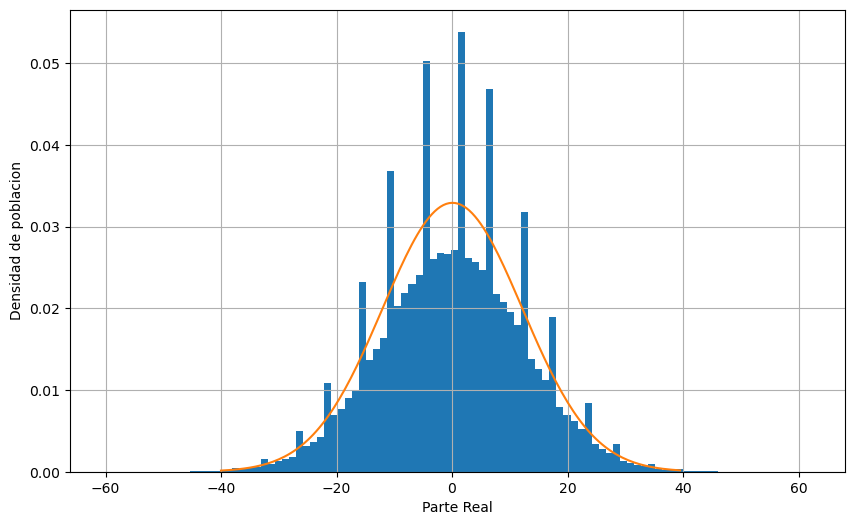

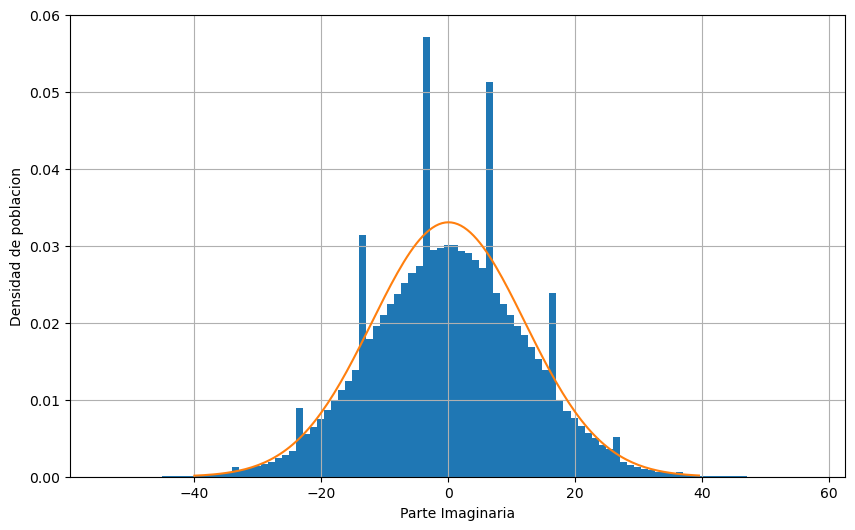

In [22]:
# 2- Realizar un histograma
# 3- Normalizar el histograma para que el area encerrada sea igual a 1
# 4- Superponer el histograma normalizado con una funcion PDF gaussiana

# Calculo desviacion estandar para la funcion de densidad de poblacion.
x = np.arange(-40, 40, step=0.5)
std_real = np.std(real)
std_imag = np.std(imag)
normal_real = norm(mean_real, std_real)
normal_imag = norm(mean_imag, std_imag)
pdf_real = normal_real.pdf(x)
pdf_imag = normal_imag.pdf(x)

# Histograma parte real
plt.figure(figsize=(10,6))
plt.xlabel("Parte Real")
plt.ylabel("Densidad de poblacion")
plt.hist(real, bins=100, density=True)
plt.plot(x, pdf_real)
plt.grid(True)
plt.show()

# Histograma parte imaginaria
plt.figure(figsize=(10,6))
plt.xlabel("Parte Imaginaria")
plt.ylabel("Densidad de poblacion")
plt.hist(imag, bins=100, density=True)
plt.plot(x, pdf_imag)
plt.grid(True)
plt.show()

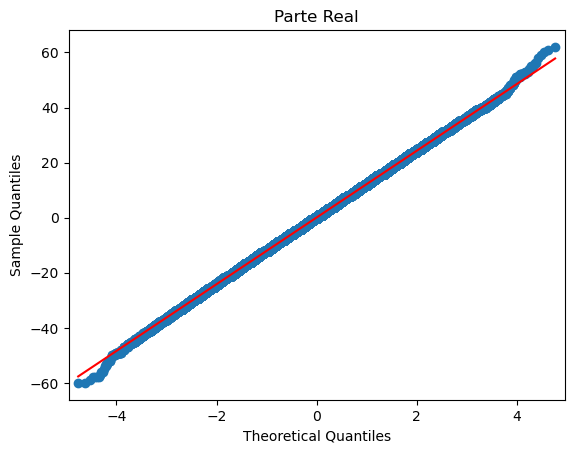

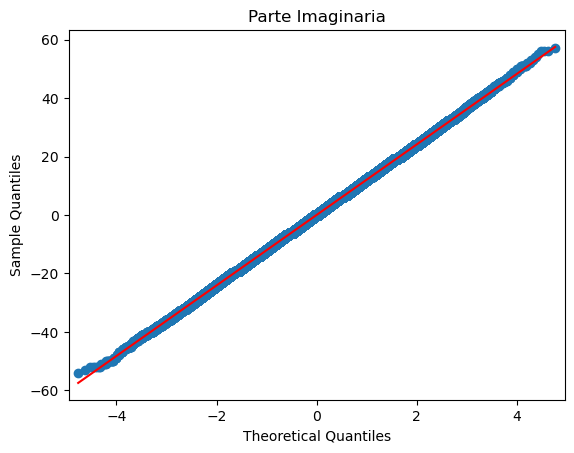

In [23]:
# 5- Analizar la gaussianidad mediante un grafico Q-Q haciendo uso de qqplot
qqplot(real, line='s')
plt.title("Parte Real")
plt.show()

qqplot(imag, line='s')
plt.title("Parte Imaginaria")
plt.show()

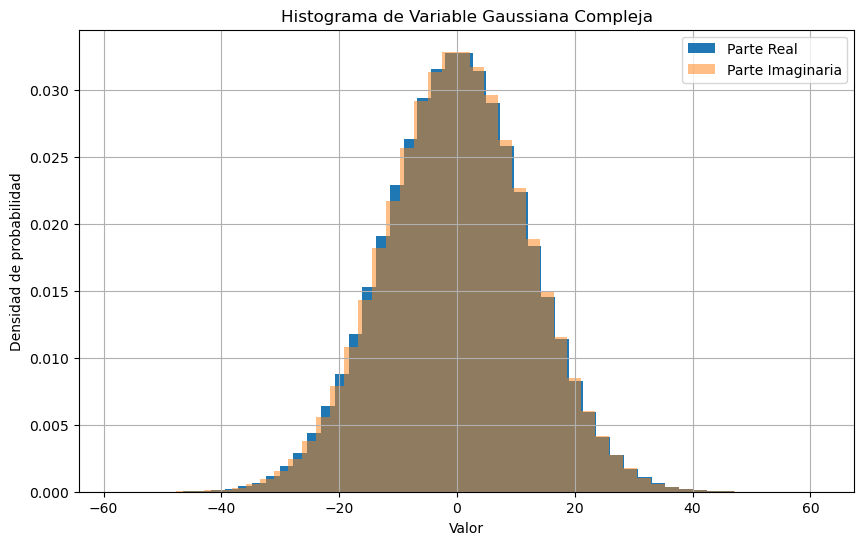

In [24]:
# 6- Generar mediante un código, una variable gaussiana compleja que tenga la misma media y varianza que la señal muestreada y obtener su histograma.

gaussian_real = np.random.normal(mean_real, np.sqrt(var_real), len(real))
gaussian_imag = np.random.normal(mean_imag, np.sqrt(var_imag), len(imag))

# Combino las partes real e imaginaria para formar una variable gaussiana compleja
gaussian_complex = gaussian_real + 1j * gaussian_imag

# Calculo el histograma de la parte real e imaginaria de la variable gaussiana compleja
plt.figure(figsize=(10, 6))
plt.hist(np.real(gaussian_complex), bins=50, density=True, label='Parte Real')
plt.hist(np.imag(gaussian_complex), bins=50, density=True, alpha=0.5, label='Parte Imaginaria')
plt.title('Histograma de Variable Gaussiana Compleja')
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.legend()
plt.grid(True)
plt.show()

## Gráfica temporal de la señal recibida

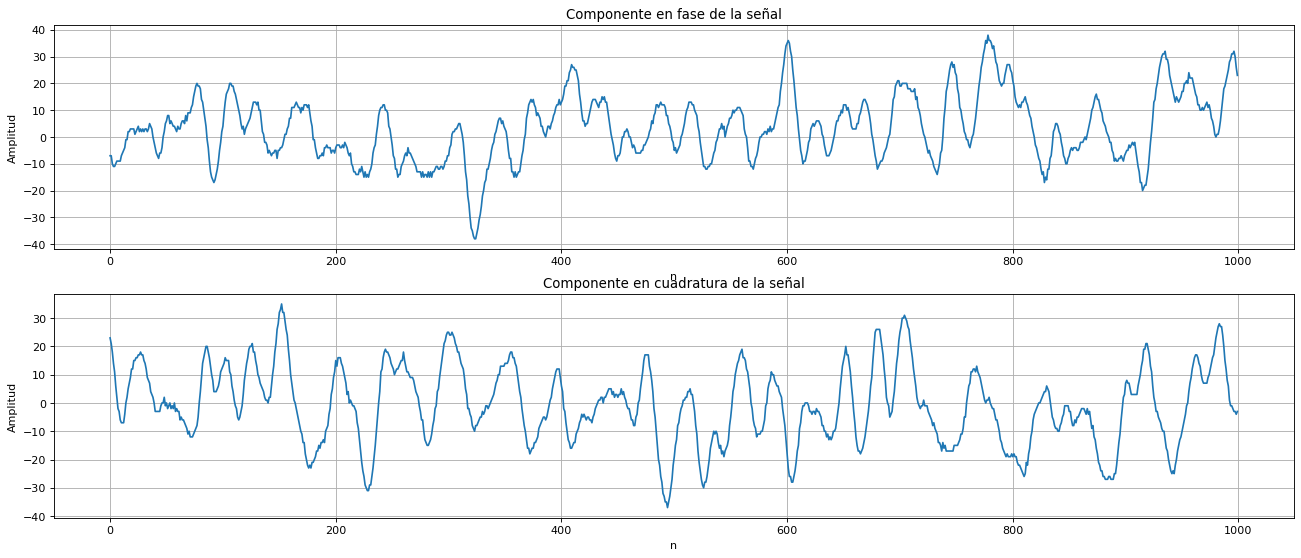

In [25]:
plotSignal(rxSignal[0:1000])

## Gráfica de la densidad espectral de potencia de la señal recibida

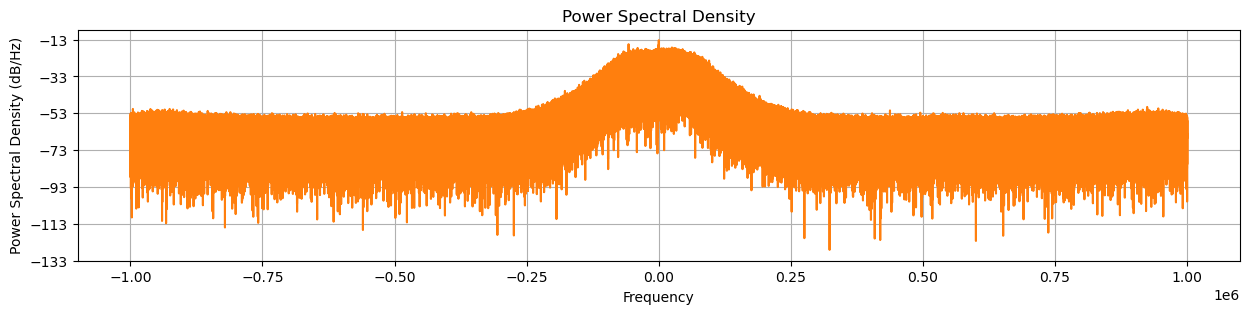

In [26]:
plotSpect(rxSignal,samplingRate)

## Finalizando la experiencia
Dado que no es posible apagar la etapa transmisora del SDR, es recomendable antes de finalizar la experiencia, dejar configurado el transmisor con la máxima atenuación posible, asegurarse que las frecuencias de transmisión y recepción no coinciden y cargar al Buffer transmisor con ceros. Esto permitirá minimizar cualquier posible interferencia por parte del SDR.

In [27]:
# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr.tx_destroy_buffer()
sdr.tx_hardwaregain_chan0 = -89 
sdr.tx_lo                 = int(2400e6)
sdr.rx_lo                 = int(950e6)
sdr.tx(np.zeros(2048))

In [28]:
# Destroy radio object
del(sdr)